# DMML-03

Modelltanítás, `scikit-learn`, keresztvalidáció,
hiperparaméter-optimalizálás.

<strong>Honlap:</strong>
<a href="https://apagyidavid.web.elte.hu/2025-2026-1/dmml"
target="_blank">apagyidavid.web.elte.hu/2025-2026-1/dmml</a>

<a target="_blank" href="https://colab.research.google.com/github/dapagyi/dmml-web/blob/gh-pages/notebooks/dmml-03.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Döntési fák

## Felépítés

-   Fa, háromféle csúcs:
    -   gyökér (root),
    -   belcső csúcs (internal node),
    -   levél (leaf/terminal node).
-   Levelek címkézve vannak a célváltozó értékeivel.
-   A többi csúcsban kérdések a leíró változókról.

## Klasszifikáció döntési fával

-   Elindulunk a gyökérből:
    -   Ha levélbe érkezünk, akkor a levél címkéje a klasszifikált
        címke.
    -   Ha belső csúcsba érkezünk, kiértékeljük az ott lévő kérdést,
        aszerint megyünk tovább.

## Döntési fa építése (Hunt algoritmusa)

-   Gyökérből indulunk.
-   Egy adott $t$ csúcsra megnézzük, hogy a tanítóadat mely $D_t$
    részhalmaza jut le oda:
    -   Ha mindegyiknek valamilyen $y_t$ a címkéje, akkor $t$ levél, a
        címkéje $y_t$
    -   Ha több osztályba tartoznak, kiválasztunk egy $a_t$ leíró
        változót, és annak az értékei alapján létrehozzuk $t$ gyerekeit

## Hogyan válasszunk jó célváltozót?

Legyen $\mathbb{P}(y = y_i) = p_i$: egy adott csúcsba jutó adatpontok
hanyadrésze $y_i$ címkéjű.

-   Gini-index: $$G(y) = \sum_{i=1}^C p_i (1-p_i)$$
-   Entrópia vagy logloss: $$H(y) = -\sum_{i=1}^C p_i\log p_i$$

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    ConfusionMatrixDisplay,
)
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt


df = pd.read_csv("https://apagyidavid.web.elte.hu/2025-2026-1/dmml/data/titanic.csv")
df.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1, inplace=True)
df.fillna({"Age": df["Age"].median(), "Embarked": df["Embarked"].mode()[0]}, inplace=True)

label_enc = LabelEncoder()
df["Sex"] = label_enc.fit_transform(df["Sex"])
df["Embarked"] = label_enc.fit_transform(df["Embarked"])

X = df.drop("Survived", axis=1)
y = df["Survived"]

X.head()

In [2]:
model = DecisionTreeClassifier()
model

In [3]:
model.fit(X, y)

'Misclassified: 18'

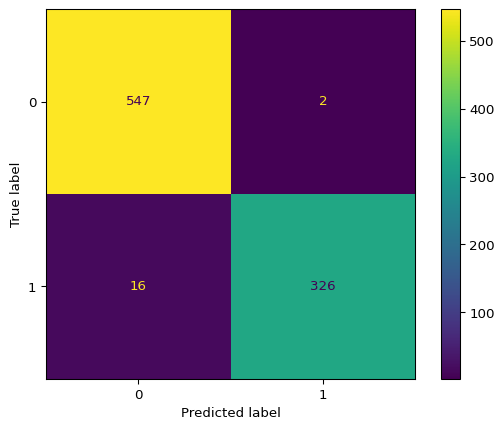

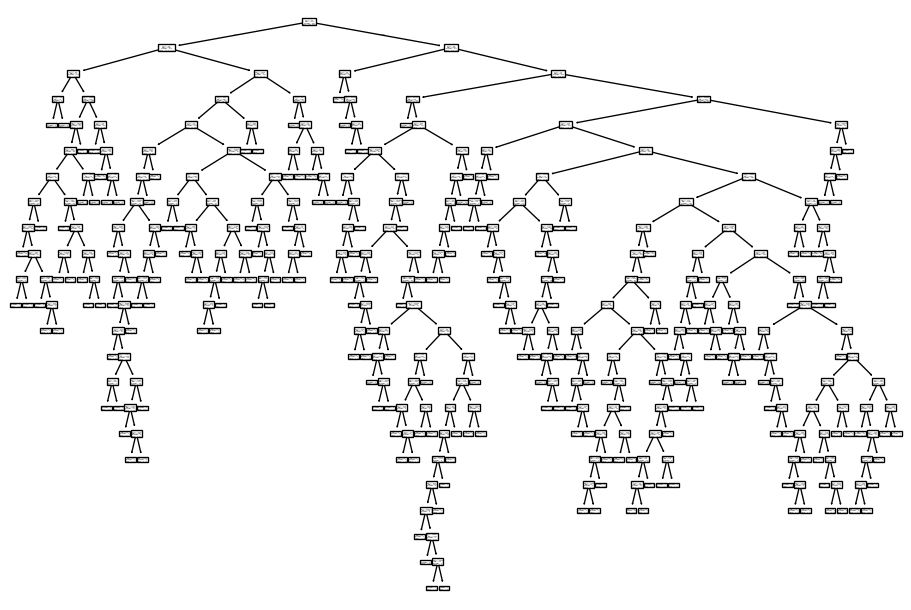

In [4]:
preds = model.predict(X)
display(f"Misclassified: {sum(abs(y - preds))}")
cm = confusion_matrix(y, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))
plot_tree(model, ax=ax)
plt.show()

tree = model.tree_
tree.max_depth, len(X), tree.node_count, model.get_depth()

Az $n$ mélységű döntési fa (a példában 22) leveleinek maximális száma (a
fa *kapacitása*) $2^{n-1}$, ami *jóval nagyobb*, mint a mintahalmaz
mérete. Ebből adódóan a modell, ha más tényezők nem szólnának közbe,
akár az *egész adathalmazt* megtanulhatná. Ez a *túltanulás*
(*overfitting*) jelensége, ami miatt a modell az új, ismeretlen adatokon
már nem fog jól teljesíteni.

'Misclassified: 154'

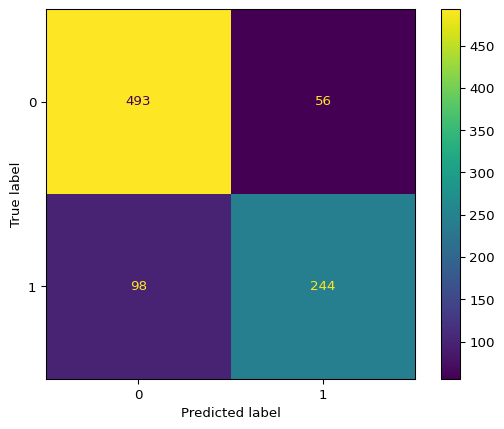

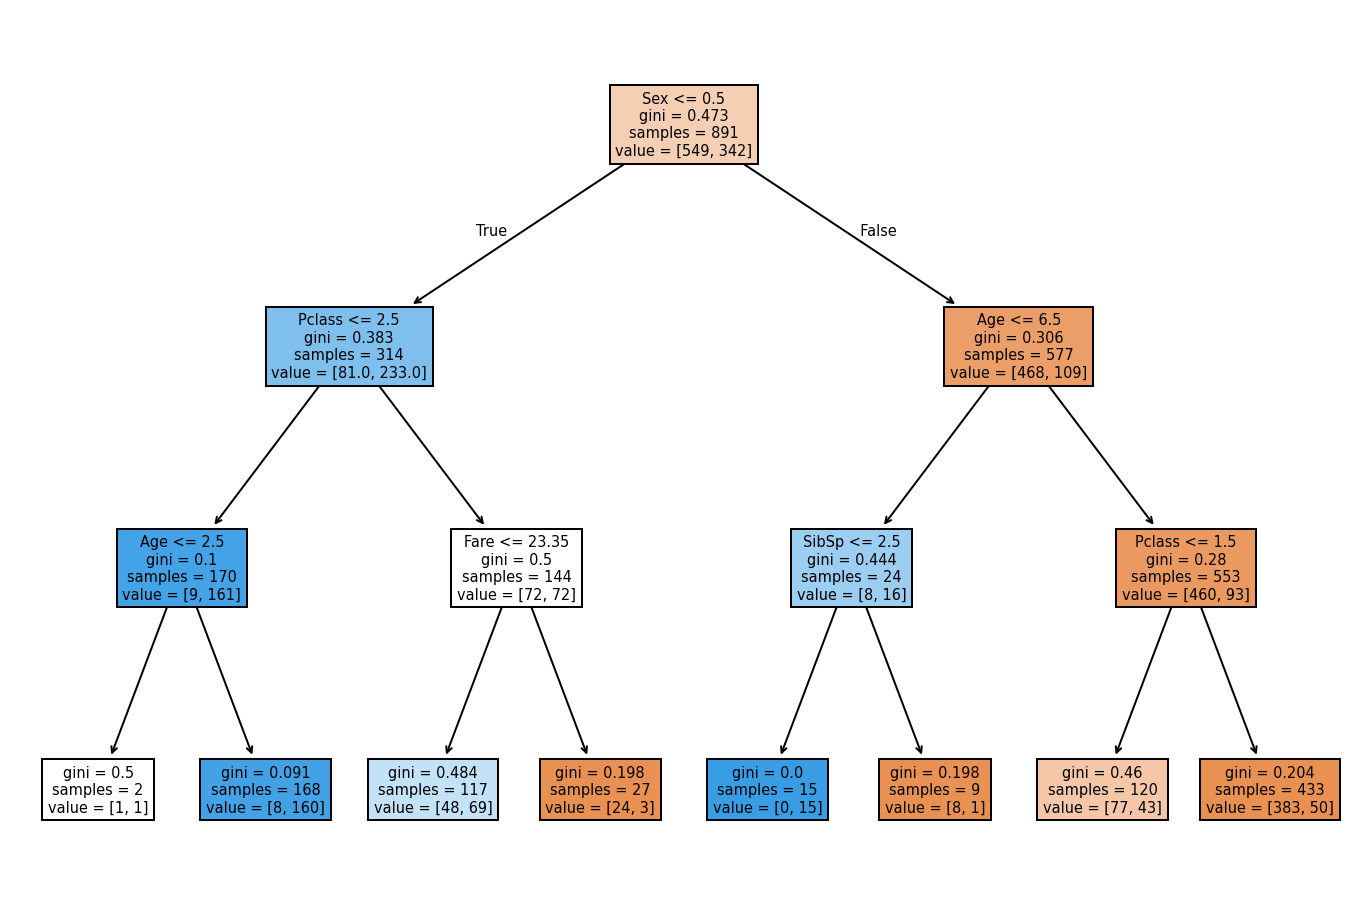

In [5]:
model = DecisionTreeClassifier(max_depth=3)
model.fit(X, y)
preds = model.predict(X)
display(f"Misclassified: {sum(abs(y - preds))}")
cm = confusion_matrix(y, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

fig, ax = plt.subplots(figsize=(12, 8), dpi=144)
plot_tree(model, ax=ax, feature_names=X.columns, filled=True)
plt.show()

tree = model.tree_
tree.max_depth, len(X), tree.node_count, model.get_depth()

# Keresztvalidálás, hiperparaméter-optimalizálás

-   [3.1. Cross-validation: evaluating estimator
    performance](https://scikit-learn.org/stable/modules/cross_validation.html)
-   [3.2. Tuning the hyper-parameters of an
    estimator](https://scikit-learn.org/stable/modules/grid_search.html)

In [6]:
records = []
params = {"max_depth": 3, "min_samples_split": 5, "random_state": 42}

for criterion in ["gini", "log_loss"]:
  cv = KFold(n_splits=5, shuffle=True, random_state=42)

  for fold, (train_index, test_index) in enumerate(cv.split(X)):

    model = DecisionTreeClassifier(criterion=criterion, **params)

    X_train_, y_train_ = X.loc[train_index], y[train_index]
    X_test_, y_test_ = X.loc[test_index], y[test_index]

    model.fit(X_train_, y_train_)
    preds = model.predict(X_test_)
    score = f1_score(y_test_, preds)

    record = {"criterion": criterion, "fold": fold, "f1_score": score}
    records.append(record)

metrics = pd.DataFrame().from_records(records)
display(metrics)
metrics.groupby("criterion")["f1_score"].agg(["mean", "std"])

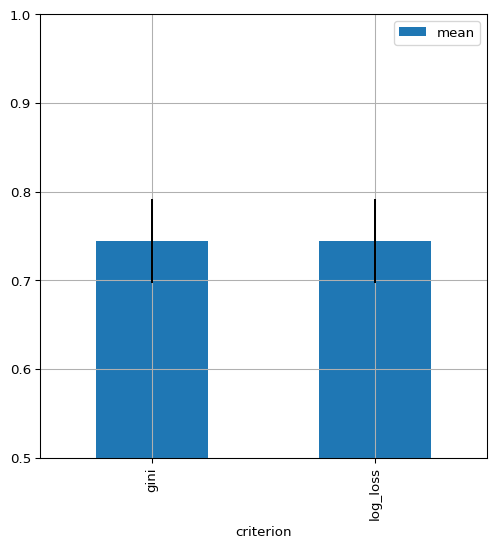

In [7]:
metrics.groupby("criterion")["f1_score"].agg(["mean", "std"]).plot.bar(
    y="mean", yerr="std", ylim=(0.5, 1.0), grid=True, figsize=(6, 6)
)

Ennek a vizualizációnak persze nincs sok értelme ebben a formában.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 10, 20],
}

model = DecisionTreeClassifier()
grid_search = GridSearchCV(model, param_grid, cv=5, verbose=3, scoring="f1")
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END criterion=gini, max_depth=None, min_samples_split=2;, score=0.660 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_split=2;, score=0.685 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=None, min_samples_split=2;, score=0.686 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=None, min_samples_split=2;, score=0.667 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=None, min_samples_split=2;, score=0.684 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=None, min_samples_split=10;, score=0.698 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=None, min_samples_split=10;, score=0.699 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=None, min_samples_split=10;, score=0.722 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=None, min_samples_split=10;, score=0.667 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=None, min_samp

## Optuna

> Optimize Your Optimization; An open source hyperparameter optimization
> framework to automate hyperparameter search

-   [Optuna](https://optuna.org/)
-   [scikit-learn
    example](https://github.com/optuna/optuna-examples/blob/main/sklearn/sklearn_simple.py)